# Problem 2 - Image Sharpening

In [2]:
import numpy as np
import cv2 as cv
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
plt.style.use('ggplot')
from scipy.ndimage.filters import gaussian_filter
import scipy.stats as st
import helper as hp # contains helper functions
%matplotlib inline

#### Loading Image and adding noise

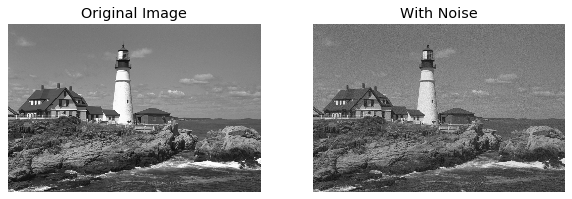

In [3]:
img_org = cv.imread('./lighthouse2.bmp', cv.IMREAD_GRAYSCALE)
rows, cols = img_org.shape;
img_org = np.float32(img_org)

noise = np.ones((rows,cols), np.float32)
noise_sigma = 10; var_z = noise_sigma**2;

noise = cv.randn(noise, 0, noise_sigma)
img_org = np.float32(img_org)
img_noise = img_org + noise;

plt.rcParams["figure.figsize"] = (10,6);
hp.subShow(1,2,1, img_org, 'Original Image')
hp.subShow(1,2,2, img_noise, 'With Noise')
plt.show()

#### Add Gaussian noise

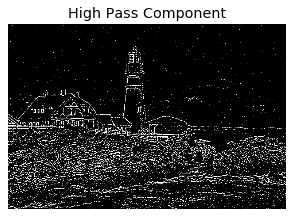

In [4]:
ker = hp.gaussianKernel(3, 1)
uy = cv.filter2D(img_noise, cv.CV_32F, ker)

hp_filter = np.float32([[-1,-1,-1], [-1,8,-1], [-1,-1,-1]])
y1 = cv.filter2D(uy, cv.CV_32F, hp_filter)

y11 = y1 > 40
plt.rcParams["figure.figsize"] = (5,5);
plt.imshow(y11, cmap='gray'), plt.title('High Pass Component'), plt.xticks([]), plt.yticks([]);   
plt.savefig('q2/hp_comp.jpg', dpi= 200, bbox_inches='tight', transparent=False)
plt.show()

## Part - 1: Constant Gain

In [5]:
def amplifyHP(uy, y1, factor):
    x_hat = uy + factor * y1;
    x_hat[x_hat > 255] = 255
    x_hat[x_hat < 0] = 0
    return x_hat

#### Getting optimal gain value

Best factor: 0.130653266332


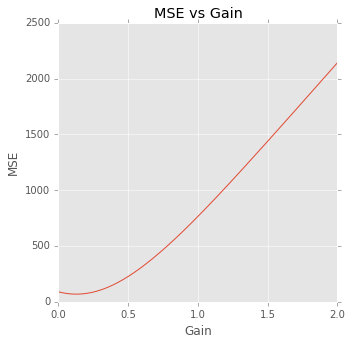

In [6]:
vec_mse = []
factor_list = np.linspace(0, 2, 200);
best_factor, best_mse = None, 1e30;

for factor in factor_list:
    x_hat = amplifyHP(uy, y1, factor)
    mse = hp.getMSE(x_hat, img_org)
    vec_mse.append(mse)
    if best_mse > mse:
        best_mse = mse
        best_factor = factor

print('Best factor:', best_factor)
plt.rcParams["figure.figsize"] = (5,5);
plt.plot(factor_list, vec_mse)
plt.xlabel('Gain'), plt.ylabel('MSE'), plt.title('MSE vs Gain')
plt.savefig('q2/mse_gain_comp.jpg', dpi= 200, bbox_inches='tight', transparent=False)
plt.show()

#### Comparing results with different gain values 

MSE 89.6144917806
MSE 68.630742391


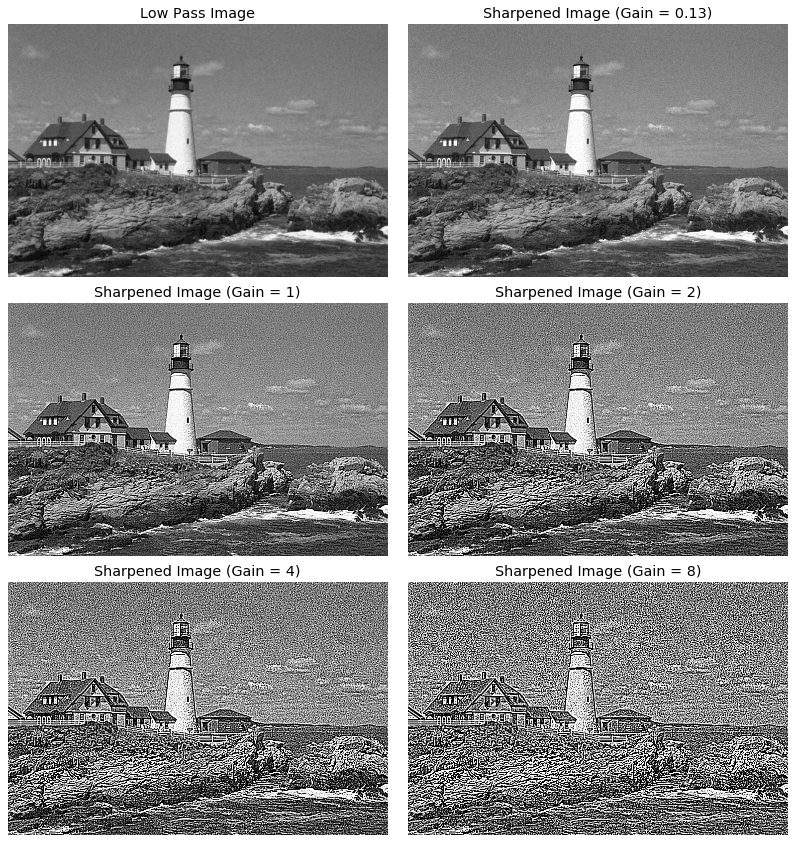

In [9]:
x_hat_const = amplifyHP(uy, y1, best_factor)
x_gain1 = amplifyHP(uy, y1, 1)
x_gain2 = amplifyHP(uy, y1, 2)
x_gain3 = amplifyHP(uy, y1, 4)
x_gain4 = amplifyHP(uy, y1, 8)

print('MSE', hp.getMSE(uy, img_org))
print('MSE', hp.getMSE(x_hat_const, img_org))
%matplotlib inline
plt.rcParams["figure.figsize"] = (14,15)
hp.subShow(3,2,1, uy, 'Low Pass Image')
hp.subShow(3,2,2, x_hat_const, 'Sharpened Image (Gain = 0.13)')
hp.subShow(3,2,3, x_gain1, 'Sharpened Image (Gain = 1)')
hp.subShow(3,2,4, x_gain2, 'Sharpened Image (Gain = 2)')
hp.subShow(3,2,5, x_gain3, 'Sharpened Image (Gain = 4)')
hp.subShow(3,2,6, x_gain4, 'Sharpened Image (Gain = 8)')

plt.subplots_adjust(wspace=0.05, hspace=.001)
plt.savefig('q2/lp_gain_comp.jpg', dpi= 200, bbox_inches='tight', transparent=False)
plt.show()

## Part - 2: Variable Gain

In [10]:
def amplify_varHP(m, t):
    abs_y1 = np.abs(y1);
    hp_comp = np.zeros(uy.shape, np.float32)
    rows, cols = abs_y1.shape

    hp_comp[abs_y1 > t] = m * t 
    hp_comp[abs_y1 <= t] = m * abs_y1[abs_y1 <= t]
    
    x_hat = uy + hp_comp * y1;
    x_hat[x_hat > 255] = 255
    x_hat[x_hat < 0] = 0
    return x_hat

#### Getting optimal parameters 'm' and 't'

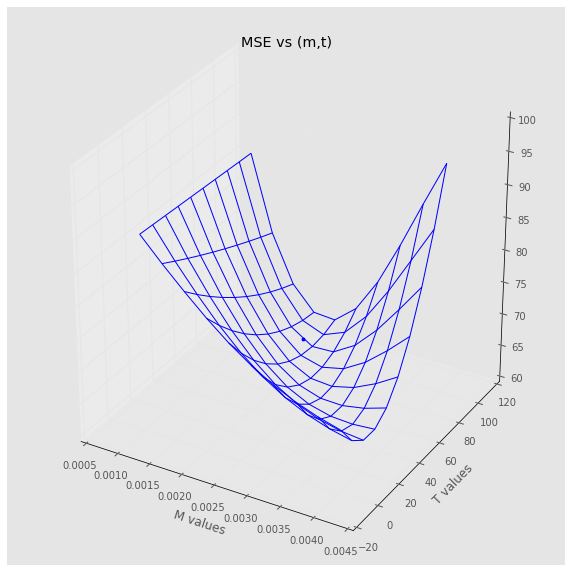

Best (m = 0.002000, t = 89.000000, mse:63.310888)


In [11]:
m_list = np.linspace(.001, .004, 10)
t_list = np.linspace(1, 100, 10)
X, Y = np.meshgrid(m_list, t_list)
best_m, best_t, best_mse = None, None, 1e30;
vec_mse = []

%matplotlib inline
Z = np.ndarray( (len(m_list), len(t_list)), dtype = np.float32)

for i in range(len(X)):
    m = m_list[i]
    for j in range(len(Y)):
        t = t_list[j]
        x_hat = amplify_varHP(m, t)
        mse = hp.getMSE(x_hat, img_org)
        Z[i,j] = mse
        vec_mse.append(mse)
        if best_mse > Z[i,j]:
            best_mse, best_m, best_t = mse, m, t
       
plt.rcParams["figure.figsize"] = (10,10)
fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1)

x_hat = amplify_varHP(best_m, best_t)
mse = hp.getMSE(x_hat, img_org)
ax.scatter(best_m, best_t, mse);

plt.xlabel('M values')
plt.ylabel('T values')

plt.title('MSE vs (m,t)')
plt.show()
print('Best (m = {:f}, t = {:f}, mse:{:f})'.format(best_m, best_t, best_mse))

#### Plotting Gain value vs y1 

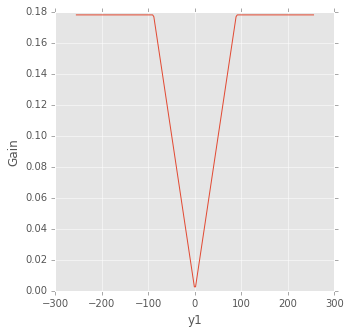

In [12]:
y1_list = np.linspace(-255, 255, 200);
res = np.zeros(len(y1_list), np.float32)
# res = best_m * best_t

# for i in range(len(y1_list)):
#     if y1_abs[i] > best_t:
#         res[i] = best_m * best_t 
#     else:
#         res[i] = 
y1_abs = np.abs(y1_list)


res[y1_abs <= best_t] = best_m * y1_abs[y1_abs <= best_t]
res[y1_abs > best_t] = best_m * best_t

plt.rcParams["figure.figsize"] = (5,5)
plt.plot(y1_list, res)
plt.xlabel('y1')
plt.ylabel('Gain')
plt.savefig('q2/gain_func.jpg', dpi= 200, bbox_inches='tight', transparent=False)
plt.show()

#### Comparing Second scale results

MSE 63.3108876546


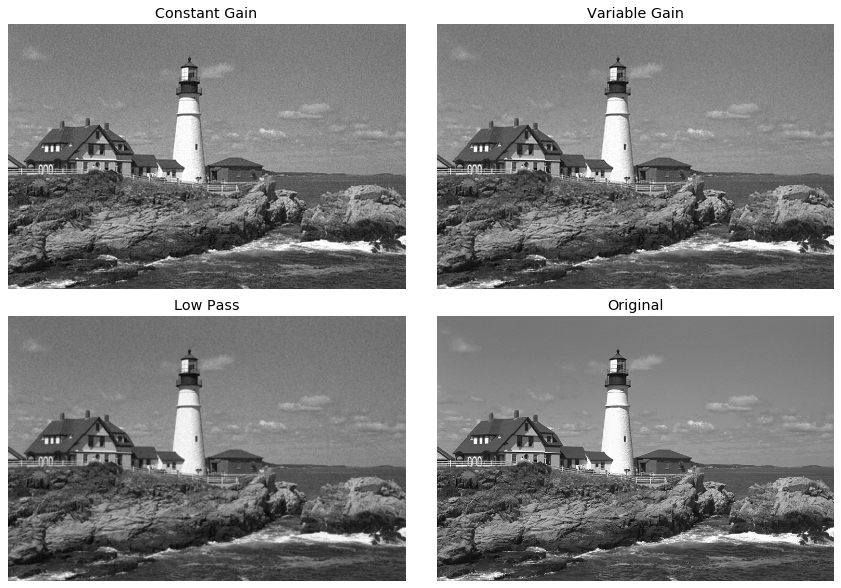

In [13]:
x_hat_var = amplify_varHP(best_m, best_t)
# x_hat = hp.saturate(x_hat)
print('MSE', hp.getMSE(x_hat_var, img_org))

%matplotlib inline
plt.rcParams["figure.figsize"] = (15,10)
hp.subShow(2,2,1, x_hat_const, 'Constant Gain')
hp.subShow(2,2,2, x_hat_var, 'Variable Gain')
hp.subShow(2,2,3, uy, 'Low Pass')
hp.subShow(2,2,4, img_org, 'Original')
# hp.subShow(2,2,3, x_hat_const, 'Constant Gain')

plt.subplots_adjust(wspace=0.05, hspace=.1)
plt.savefig('q2/var_gain.jpg', dpi= 200, bbox_inches='tight', transparent=False)
plt.show()

#### Comparing results for different combinations of 'm' and 't' 

MSE 15088.4960938
MSE 89.5916239421
MSE 69.6244049072
MSE 68.7775268555


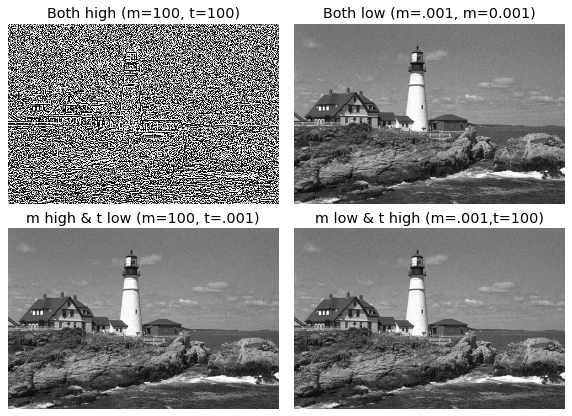

In [14]:
x_var1 = amplify_varHP(100, 100)
x_var2 = amplify_varHP(.001, 0.001)
x_var3 = amplify_varHP(100, .001)
x_var4 = amplify_varHP(.001, 100)
# x_hat = hp.saturate(x_hat)

print('MSE', hp.getMSE(x_var1, img_org))
print('MSE', hp.getMSE(x_var2, img_org))
print('MSE', hp.getMSE(x_var3, img_org))
print('MSE', hp.getMSE(x_var4, img_org))


%matplotlib inline
plt.rcParams["figure.figsize"] = (10,7)
hp.subShow(2,2,1, x_var1, 'Both high (m=100, t=100)')
hp.subShow(2,2,2, x_var2, 'Both low (m=.001, m=0.001)')
hp.subShow(2,2,3, x_var2, 'm high & t low (m=100, t=.001)')
hp.subShow(2,2,4, x_var2, 'm low & t high (m=.001,t=100)')
# hp.subShow(2,2,3, x_hat_const, 'Constant Gain')

plt.subplots_adjust(wspace=0.05, hspace=.1)
plt.savefig('q2/mt_gain.png', dpi= 200, bbox_inches='tight', transparent=False)
plt.show()